In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

from helper_functions import find_outlier_games, kfold_validate_score, kfold_validate_pred, var_plot

In [2]:
# Import processed data from EDA notebook
bgg = pd.read_csv('./data/bgg_processed.csv', index_col='game_id')

In [3]:
# Split off target column: `avg_rating`
y = bgg['avg_rating']
X = bgg.drop('avg_rating', axis=1).copy()

In [4]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Initial linear regression

First let's see how simple linear regression fares. There are 2000 entries in the original data, so the train/test split leaves 1600 rows in the training data. 8 splits for K-Fold cross validation should ve sufficient so each slice is 200 rows. The rows were already shuffled with the train/test split, so they don't need shuffled again.

In [5]:
# Find mean RMSE through linear regression over 8 fold
kfold_validate_score(X_train, y_train)

20290175055.225716

Clearly, something isn't optimal. The range between the minimum score and maximum score is 2.7 points. We'd want the average RMSE to be smaller than this range, not 20 billion.

In [6]:
# Create the scores used by the previous function
scores = -1 * cross_val_score(
    LinearRegression(),
    X_train,
    y_train,
    scoring='neg_mean_squared_error',
    cv=KFold(n_splits=8)
)

In [7]:
# Look at scores from each split
for i in scores:
    score = np.sqrt(i)
    print(f'Slice {list(scores).index(i)} RMSE: {score}')

Slice 0 RMSE: 0.44547528136469133
Slice 1 RMSE: 0.3831761390119257
Slice 2 RMSE: 0.3741414727970673
Slice 3 RMSE: 0.36228473775631453
Slice 4 RMSE: 0.31812747589049367
Slice 5 RMSE: 0.3616080264109322
Slice 6 RMSE: 0.39168740199763735
Slice 7 RMSE: 162321400439.16922


There is something in the 8th slice that is going wrong. Let's dig in a little to see what it is. First, we need to see what the CV is actually predicting:

In [8]:
# Generate predictions from the cross validation
preds = kfold_validate_pred(X_train, y_train)
preds

array([7.18031593, 7.14230428, 6.73584719, ..., 7.52238108, 7.22286393,
       7.19165134])

In [9]:
print(f'Max prediction: {np.max(preds)}\nMin prediction: {np.min(preds)}')

Max prediction: 11.409906691914584
Min prediction: -2295571259637.283


It looks like the highest prediction is within reason. Ideally, we'd want it below 10, but it isn't too far off. The lowest prediction is causing a problem.

In [10]:
# Find index of smallest prediction in X_train
outlier_idx = X_train.iloc[[list(preds).index(np.min(preds))]].index[0]
outlier_idx

46213

In [11]:
# Load the names df
names = pd.read_csv('./data/bgg_names.csv', index_col='game_id')

In [12]:
# Find name of game causing the issue
names.loc[outlier_idx][0]

'Telestrations'

The model is predicting a very anomalous result for the game called "Telestrations". Is this a result that is specific for 8 k-fold slices?

In [13]:
# find_outlier_games returns {Game Name: Predicted Score} for any game
# where predicted score is -20 < score < 20
for i in range(2, 21):
    outliers = find_outlier_games(X_train, y_train, names, i)
    print(f'{i} folds - Outlier games:')
    print('\t', outliers)

2 folds - Outlier games:
	 {'Diplomacy': 12190501.043050587, 'Blood on the Clocktower': 12190501.304880919, 'Ra': 210282895078.39734, 'The Estates': 210282895077.12515, 'Wings of War: Famous Aces': 115311218752.27881, 'Paths of Glory': 115311218751.66248, 'The Grizzled': 115311218751.20435, 'No Thanks!': 210282895077.02087, 'Cosmic Encounter': 12190500.91224652, 'History of the World': 115311218751.24864, 'A Game of Thrones: The Board Game (Second Edition)': 12190501.32368377, 'Nightmare Productions': 210282895077.4625, 'Cosmic Encounter: 42nd Anniversary Edition': 12190501.28717232, 'Tiny Epic Kingdoms': 12190500.60113901, 'Citadels': -653071117.8103834, 'Arkham Horror': -653071117.7523369, 'Rhino Hero': -653071118.2375696, 'Telestrations': -118812254626.68163}
3 folds - Outlier games:
	 {'Ra': 3502737523324.3457, 'The Estates': 3502737523323.9014, 'Wings of War: Famous Aces': 241372749046.84573, 'Paths of Glory': 241372749046.48447, 'The Grizzled': 241372749045.76154, 'No Thanks!': 3

### Prediction outliers

Depending on the amount of folds used, there can be more than one game receiving extreme predictions. However, no matter how many folds used, "Telestrations" always receives an extreme prediction.

#### "Telestrations" options:
 1) Remove it from analysis
 2) Use a method, such as Principle Component Regression or Princible Least Squares Regression, to reduce the features the Linear Regression model predicts off.

Some form of component reduction would be preferable if it would eleminate the need to remove games with anomalous predictions

### Removing "Telestrations"

First, let's see how the data fares without "Telestrations"

In [14]:
# Remove "Telestrations"

# Find Index
tele_idx = names[names['name']=="Telestrations"].index[0]

# Remove Game
X_train_no_tele = X_train.drop(index=tele_idx, axis=1).copy()
y_train_no_tele = y_train.drop(index=tele_idx, axis=1).copy()

In [15]:
# Find RMSE without "Telestrations"
rmse_no_tele = kfold_validate_score(X_train_no_tele, y_train_no_tele)
rmse_no_tele

0.37248410927993547

This is a much more reasonable RMSE. How does the reduced dataset perform on different slices?

In [16]:
# find_outlier_games returns {Game Name: Predicted Score} for any game
# where predicted score is -20 < score < 20
for i in range(2, 21):
    outliers = find_outlier_games(X_train_no_tele, y_train_no_tele, names, i)
    print(f'{i} folds - Outlier games:')
    print('\t', outliers)

2 folds - Outlier games:
	 {'Diplomacy': -62362018.09583988, 'Blood on the Clocktower': -62362017.83267179, 'Ra': -975682435924.0985, 'The Estates': -975682435925.3705, 'Wings of War: Famous Aces': -524821172498.9899, 'Paths of Glory': -524821172499.6047, 'The Grizzled': -524821172500.063, 'No Thanks!': -975682435925.4734, 'Cosmic Encounter': -62362018.22522544, 'History of the World': -524821172500.01807, 'A Game of Thrones: The Board Game (Second Edition)': -62362017.81186701, 'Nightmare Productions': -975682435925.0319, 'Cosmic Encounter: 42nd Anniversary Edition': -62362017.850279115, 'Tiny Epic Kingdoms': -62362018.53601172, 'Citadels': -653071117.8103834, 'Arkham Horror': -653071117.7523369, 'Rhino Hero': -653071118.2375696}
3 folds - Outlier games:
	 {'Ra': -28203743514906.65, 'The Estates': -28203743514907.09, 'Wings of War: Famous Aces': -5596261613805.6455, 'Paths of Glory': -5596261613805.712, 'The Grizzled': -5596261613806.417, 'No Thanks!': -28203743514907.14, 'History of 

There are still a number of anomalous results with some fold selections, but the majority of fold selections produce acceptable results.

### Initial Linear regression thoughts

Linear regression by itself does not seem to be a good choice for the model. There is the possibility of predicting some very high or low predictions, depending on the training data used. There is also one game in the training data that absolutely is not predicted well. This has the potential to lead to very undesirable results in production.

## Lasso Regression

In [17]:
# Find mean RMSE through lasso regression over 8 fold
lasso = LassoCV(random_state=42)

lasso_rmse = kfold_validate_score(X_train, y_train, model=lasso)
lasso_rmse

0.3406451783595732

This returns a reasonable average RMSE, but it is higher than simple linear regression without "Telestrations"

### Without Telestrations

In [18]:
# Find mean RMSE through lasso regression over 8 fold - without "Telestrations"
kfold_validate_score(X_train_no_tele, y_train_no_tele, model=lasso)

0.340596969047368

No improvement.

## Ridge Regression

In [19]:
# Find mean RMSE through ridge regression over 8 fold
ridge = RidgeCV()

ridge_rmse = kfold_validate_score(X_train, y_train, model=ridge)
ridge_rmse

0.33686227063925617

## Principle Component Regression 

In [20]:
pca = PCA(random_state=42)

X_reduced = pca.fit_transform(scale(X_train))

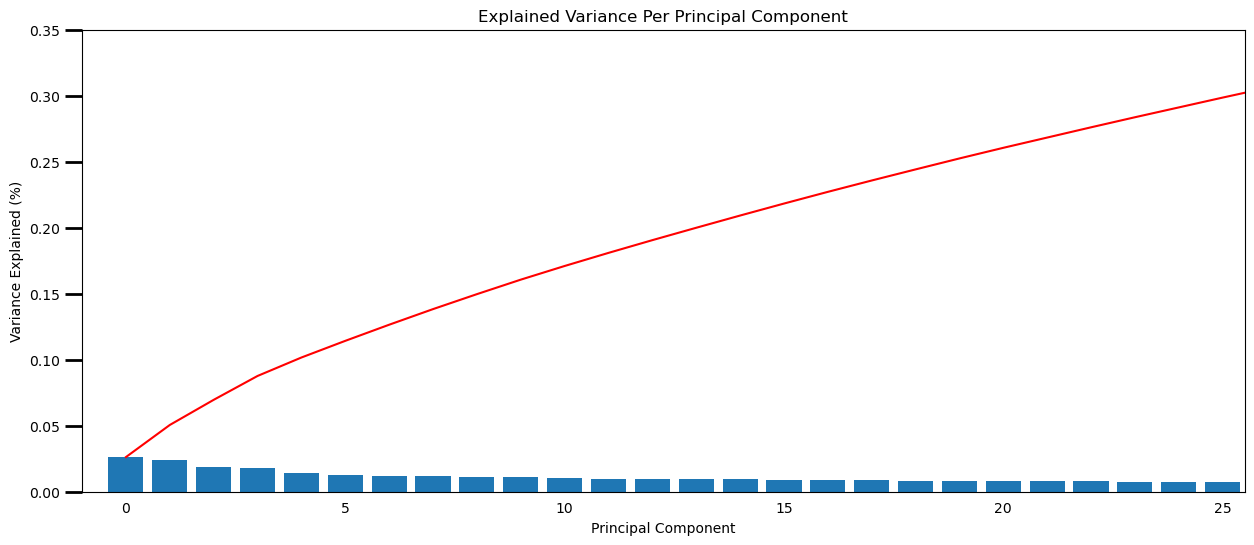

In [21]:
var_plot(pca)
plt.xlim(-1,25.5)
plt.ylim(0, 0.35);

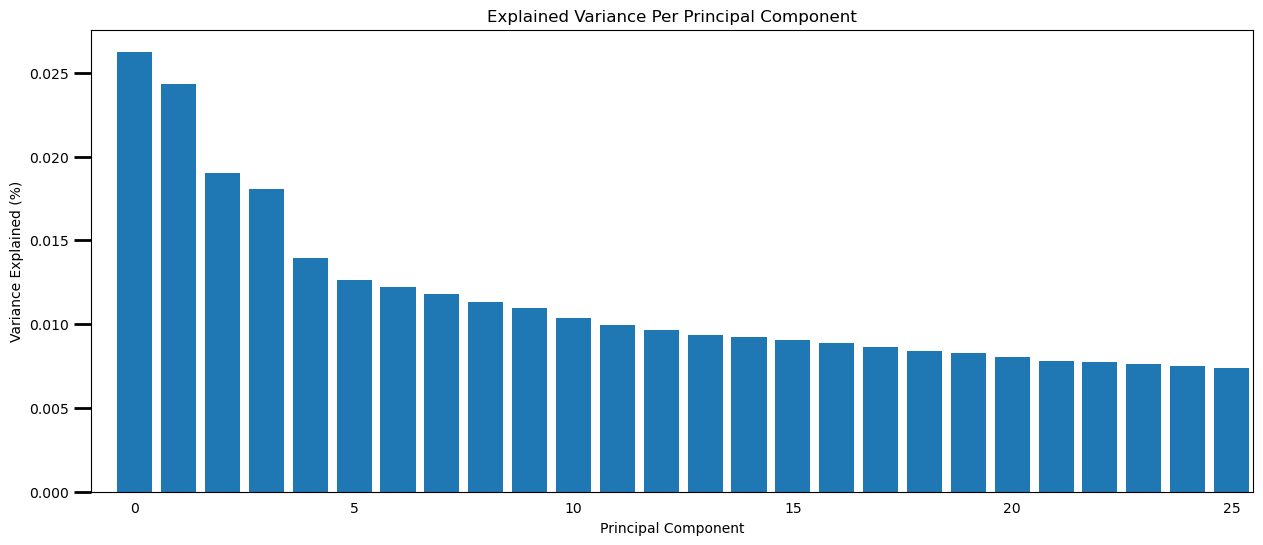

In [22]:
# Bar chart showing variance of PCA transformation with no paramaters
var_plot(pca, scree=False)

# Restrict the x-axis to allow a better view of the important data
plt.xlim(-1,25.5);

In [23]:
# Instatiate
pca_9 = PCA(9, random_state=42)

# Fit & Transform
X_train_reduced_9 = pca_9.fit_transform(X_train)

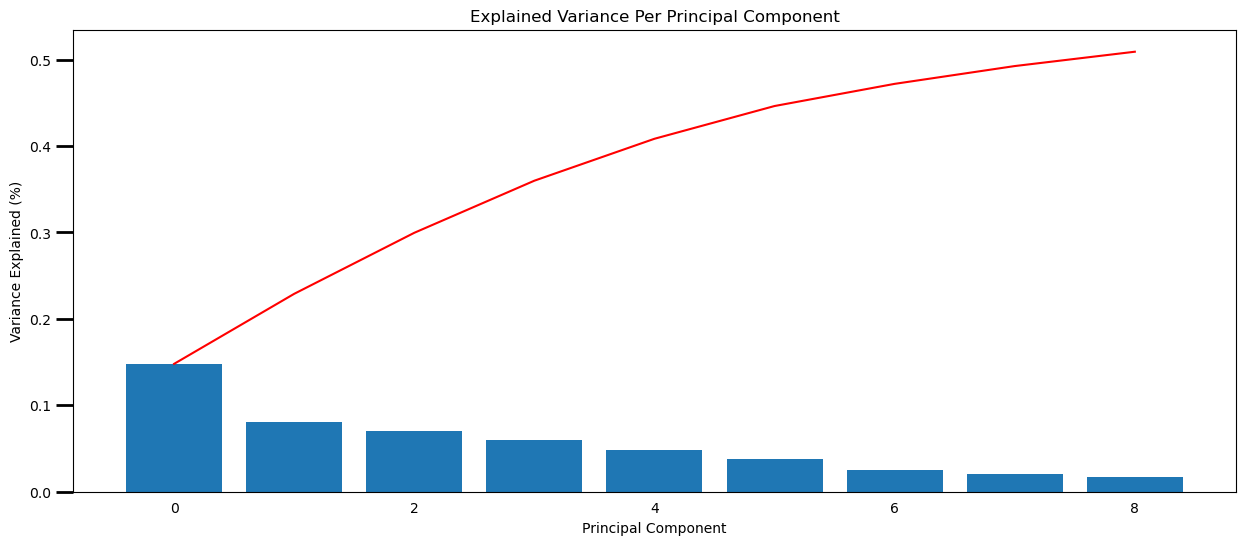

In [24]:
var_plot(pca_9)

In [25]:
# Total percentage of 9 principal components
pca_9.explained_variance_ratio_.sum()

0.5091366269665704

50% of the variance is explained by 9 PCA components.

In [26]:
# Find mean RMSE for 9 PCs
kfold_validate_score(X_reduced[:,:9], y_train)

0.3703550619452689

In [27]:
pca = PCA(random_state=42)

X_reduced = pca.fit_transform(scale(X_train))

pca_rmses = []

#Check the first 25 principle components for RMSE
for i in np.arange(1,26):
    rmse = kfold_validate_score(X_reduced[:,:i], y_train)
    pca_rmses.append(rmse)

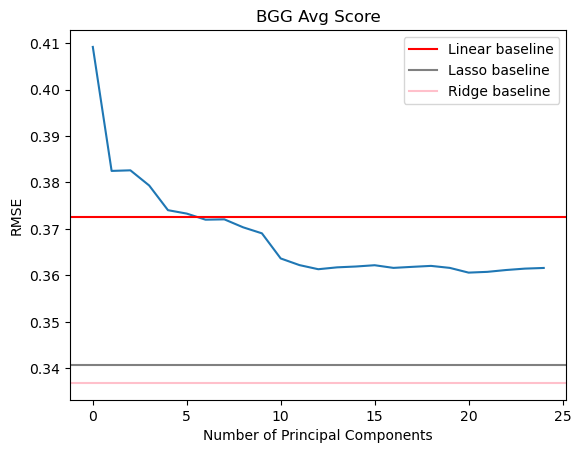

In [28]:
plt.plot(pca_rmses)

# add baselines
plt.axhline(rmse_no_tele, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

At 5 Principle Components, the model is outperforming the baseline (Simple Linear Regression with "Telestrations" removed). At 10 Principle Components, the MSE appears to be stabilizing, with no significant increase in performance with added Principle Components.

Also, this model is superior because no games have been ommited.

In [29]:
# Instatiate
pca_10 = PCA(10, random_state=42)

# Fit & Transformfrom sklearn.cross_decomposition import PLSRegression
X_train_reduced_10 = pca_10.fit_transform(X_train)

All games receive a resonable predictive score with PCR

In [30]:
# Try it with Lasso regression
pca = PCA(random_state=42)

X_reduced = pca.fit_transform(scale(X_train))

pca_rmses = []

#Check the first 25 principle components for RMSE
for i in np.arange(1,26):
    rmse = kfold_validate_score(X_reduced[:,:i], y_train, model=lasso)
    pca_rmses.append(rmse)

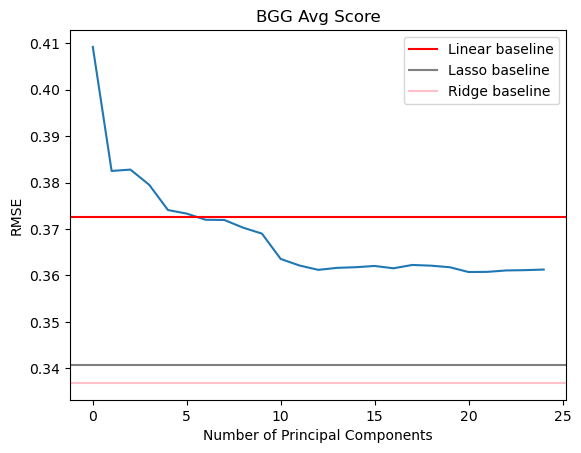

In [31]:
plt.plot(pca_rmses)

# add baselines
plt.axhline(rmse_no_tele, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

In [32]:
# Try it with Lasso regression
pca = PCA(random_state=42)

X_reduced = pca.fit_transform(scale(X_train))

pca_rmses = []

#Check the first 25 principle components for RMSE
for i in np.arange(1,26):
    rmse = kfold_validate_score(X_reduced[:,:i], y_train, model=ridge)
    pca_rmses.append(rmse)

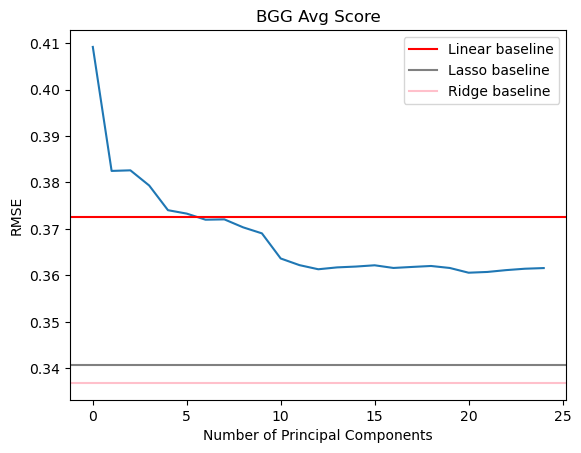

In [33]:
plt.plot(pca_rmses)

# add baselines
plt.axhline(rmse_no_tele, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

## Partial Least Squares Regression

In [34]:
pls = PLSRegression(n_components=10)
X_train_pls = pls.fit(X_train, y_train)

In [35]:
X_train_pls = pls.transform(X_train)

In [36]:
# Check mean RMSE for 10 PLS components
rmse_pls = kfold_validate_score(X_train_pls, y_train)
rmse_pls

0.2922127561217639

The RMSE is now below 0.30. This is a clear improvement using PLS.

In [37]:
linear_pls_rmses = []

#Check 1-25 PLS components for RMSE
for i in np.arange(1,26):
    pls = PLSRegression(n_components=i)

    X_train_pls = pls.fit(X_train, y_train)
    X_train_pls = pls.transform(X_train)
    
    rmse = kfold_validate_score(X_train_pls, y_train)
    
    linear_pls_rmses.append(rmse)

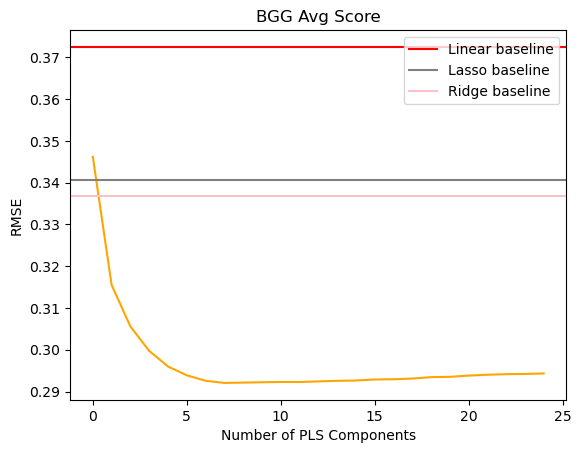

In [38]:
plt.plot(linear_pls_rmses, color='orange')

# add baselines
plt.axhline(rmse_no_tele, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

The "elbow" is around 4 PLS components, but the min is at 7 components, after which the RMSE starts increasing. This is a clear improvement over PCR.

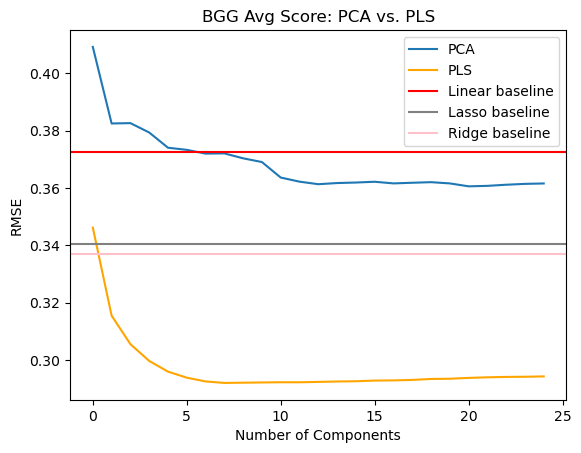

In [39]:
plt.plot(pca_rmses, label='PCA')
plt.plot(linear_pls_rmses, label='PLS', color='orange')

# add baselines
plt.axhline(rmse_no_tele, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score: PCA vs. PLS');

Comparing the two reduction methods, PLS is the clear winner, reducing the RSME from the baseline by about 25%. PCA at its best remains around the baseline, only reducing it by about 4%

In [40]:
pls = PLSRegression(n_components=7)
X_train_pls = pls.fit(X_train, y_train)
X_train_pls = pls.transform(X_train)

In [41]:
# PLS regression with 7 components - Lasso regression model
rmse_pls_lasso = kfold_validate_score(X_train_pls, y_train, model=lasso)
rmse_pls_lasso

0.2925749653068479

Like it was before feature reduction, lasso regression has an average RMSE of about 0.44

In [42]:
pls_lasso_rmses = []

#Check 1-25 PLS components for RMSE
for i in np.arange(1,26):
    pls = PLSRegression(n_components=i)

    X_train_pls = pls.fit(X_train, y_train)
    X_train_pls = pls.transform(X_train)
    
    rmse = kfold_validate_score(X_train_pls, y_train, model=lasso)
    
    pls_lasso_rmses.append(rmse)

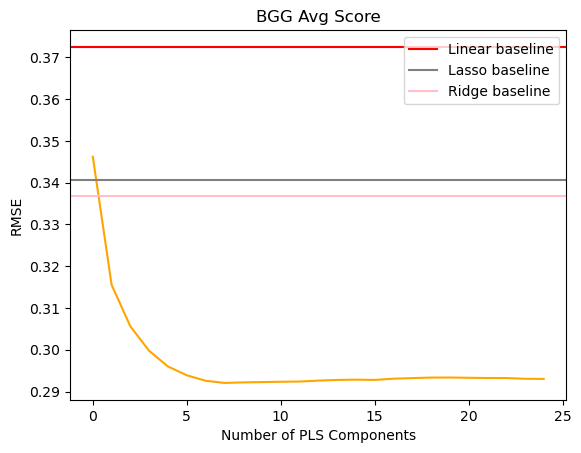

In [43]:
plt.plot(pls_lasso_rmses, color='orange')

# add baselines
plt.axhline(rmse_no_tele, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()

plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

There is no change to the mean RMSE depending on the number pf PLS Components

In [44]:
pls_ridge_rmses = []

#Check 1-25 PLS components for RMSE
for i in np.arange(1,26):
    pls = PLSRegression(n_components=i)

    X_train_pls = pls.fit(X_train, y_train)
    X_train_pls = pls.transform(X_train)
    
    rmse = kfold_validate_score(X_train_pls, y_train, model=ridge)
    
    pls_ridge_rmses.append(rmse)

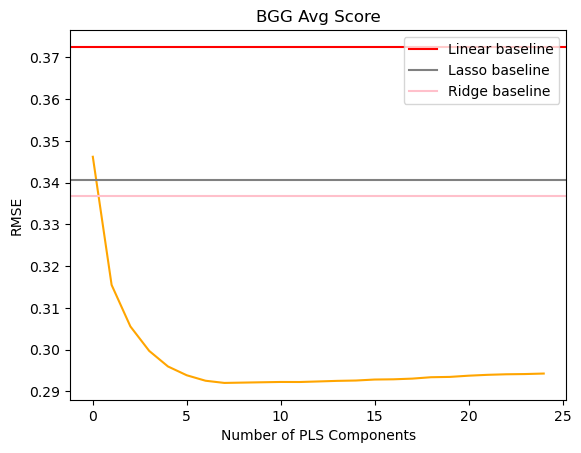

In [45]:
plt.plot(pls_ridge_rmses, color='orange')

# add baselines
plt.axhline(rmse_no_tele, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()

plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

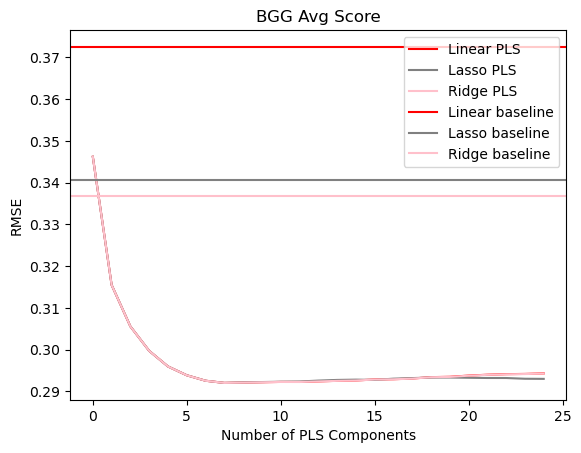

In [46]:
plt.plot(linear_pls_rmses, label='Linear PLS', color='red')
plt.plot(pls_lasso_rmses, label='Lasso PLS', color='grey')
plt.plot(pls_ridge_rmses, label='Ridge PLS', color='pink')

# add baselines
plt.axhline(rmse_no_tele, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()

plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

In [47]:
np.mean(linear_pls_rmses) - np.mean(pls_lasso_rmses)

0.00015890180448796531

In [48]:
np.mean(linear_pls_rmses) - np.mean(pls_ridge_rmses)

1.3840241249396534e-05

In [49]:
np.mean(pls_lasso_rmses) - np.mean(pls_ridge_rmses)

-0.00014506156323856878

# Final Model?

In [50]:
pls = PLSRegression(n_components=7)
X_train_pls = pls.fit(X_train, y_train)
X_train_pls = pls.transform(X_train)

In [51]:
model = LinearRegression()

In [52]:
model = model.fit(X_train_pls, y_train)

In [53]:
X_test_pls = pls.transform(X_test)

preds = model.predict(X_test_pls)

In [54]:
np.sqrt(mean_squared_error(y_test, preds))

0.3642844734281978

# Component Explanations

The components need looked at to help explain the model